# Ex. 4 Neural Networks Learning

## 1 Neural Neworks

## 1.1 Visualizing the data

In [38]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from scipy.optimize import minimize # for minimizing the cost function

In [40]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
[m,n] = X.shape  
y = y.ravel() # turn y into a 1d array
# y[y == 10] = 0 # in the Coursara's course, 
               # character '0' was labeled as '10' for the convenience in MATLAB
               # here, I change it back to '0' for the convenience in Python
# convert each character label to a vector
Y = np.zeros((m,10))
for yi,Yi in zip(y,Y):
    Yi[yi-1] = 1.0
        
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)


In [41]:
from PIL import Image

def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
#     img = scipy.misc.toimage( big_picture )
    img = Image.fromarray(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

    
def display1sample(X,y,nrow):
    """
    Display a single sample (row)
    """
    img = Image.fromarray(getDatumImg(X[nrow]))
    plt.imshow(img,cmap = cm.Greys_r)
    print(f'Labeled character is {y[nrow]}')

Labeled character is 10


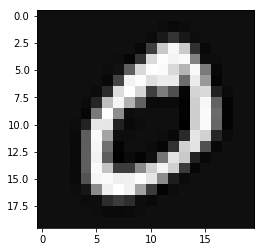

In [42]:
# Test the display functions
display1sample(X,y,0)

## 1.2 Model representation

In [43]:
weightmat = scipy.io.loadmat('data/ex4weights1.mat')

In [44]:
Theta1 = weightmat['Theta1'] # 25 by 401
Theta2 = weightmat['Theta2'] # 10 by 26

## 1.3 Feedforward the cost function

In [59]:
def H(theta1,theta2,X):
    
    """
        theta1,2: 2d array
        X: 2d of m by n
    """
    z2 = theta1 @ X.T # z2: 25 by m
    a2 = expit(z2) 
    a2 = np.insert(a2,0,1,axis=0) # a2: 26 by m
    z3 = theta2 @ a2 # z3: 10 by m
    a3 = expit(z3)
    
    return a3.T # return a 2d array of m by 10


def h(theta1,theta2,x):
    
    """
        theta1,2: 2d array
        x: 1d of n
    """    
    z2 = theta1 @ x
    a2 = expit(z2)
    a2 = np.insert(a2,0,1)
    z3 = theta2 @ a2
    a3 = expit(z3)
    
    return a3 # 1d array of 10

def forwardProg(thetalist,x):
    
    """
        thetalist: list of theta
    """
    a = []
    z = []
    a.append(x[1:]) # input layer
    for theta in thetalist:
        # propagate to next layer
        z.append(theta @ np.insert(a[-1],0,1))
        a.append(expit(z[-1]))
    
    return a[1:], z

In [60]:
h(Theta1,Theta2,X[1])

array([4.79026796e-04, 2.41495958e-03, 3.44755685e-03, 4.05616281e-05,
       6.53412433e-03, 1.75930169e-03, 1.15788527e-02, 2.39107046e-03,
       1.97025086e-03, 9.95696931e-01])

In [47]:
al, zl = forwardProg([Theta1,Theta2],X[1])

3

In [61]:
def costFunction(thetalist,X,Y):
    
    """
        Compute cost function without regularization
    """
    m = X.shape[0]
    # unvectorize
    mysum = 0
    for i in range(0,m):
        a, z = forwardProg(thetalist,X[i])
        term1 =  (- Y[i]) @ np.log(a[-1]) # a[-1] is last element of a, which is the output layer
        term2 = (1 - Y[i]) @ np.log(1 - a[-1])
        mysum += (term1 - term2)

    J = mysum / m    
    
    return J



In [62]:
def rgcostFunction(thetalist,X,Y,mylambda = 0):

    """
        Compute cost function with regularization
    """
    
    J0 = costFunction(thetalist,X,Y)
        
    rgterm = 0
    for theta in thetalist:
        rgterm += np.sum(np.square(theta[:,1:]))
    rgterm = rgterm * mylambda / (2 * X.shape[0])
    
    J = J0 + rgterm
    
    return J

In [63]:
costFunction([Theta1,Theta2],X,Y,)

0.2876291651613188

In [64]:
rgcostFunction([Theta1,Theta2],X,Y,1)

0.38376985909092354

## 2 Backpropagation

### 2.1 Sigmoid gradient

In [92]:
# Sigmoid gradient

def sigmoidGradient(z):
    g = expit(z)
    grad = g * (1 - g)
    return grad

In [93]:
sigmoidGradient(10)

4.5395807735907655e-05

### 2.2 Random initialization

In [13]:
# These are some global variables I'm suing to ensure the sizes
# of various matrices are correct
#these are NOT including bias nits
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 

eps_ini = 0.12

theta1 = np.random.random((hidden_layer_size,input_layer_size + 1 )) * 2 * eps_ini - eps_ini
theta2 = np.random.random((output_layer_size,hidden_layer_size + 1 )) * 2 * eps_ini - eps_ini

In [20]:
theta2.shape

(10, 26)

### 2.3 Backpropagation

In [ ]:
# a[]: length of 2
# z[]: length of 2

In [140]:
def gradient(thetalist,X,Y):
    
    [theta1, theta2] = thetalist
    DELTA1 = 0
    DELTA2 = 0
    for i in range(m):
        alist, zlist = forwardProg(thetalist,X[i])   # alist, zlist are lists with length of 2
                                             # Here, a = [a2, a3],  z = [z2, z3]
#         delta = [0] * len(a) # initialize delta, with the same size of a and z
        [a2,a3] = alist
        [z2,z3] = zlist
        a2 = np.insert(a2,0,1) # add the bias term ( +1 ) to the activation vectors
        a1 = np.insert(X[i],0,1)
        z2 = np.insert(z2,0,1)
        delta3 = a3 - Y[i] # 1d array of 10
        delta2 = (theta2.T @ delta3) * sigmoidGradient(z2)
        delta2 = delta2[1:]
        DELTA1 += delta2.reshape((-1,1)) @ a1.reshape((1,-1))
        DELTA2 += delta3.reshape((-1,1)) @ a2.reshape((1,-1))
    
    return DELTA1 / X.shape[0], DELTA2 / X.shape[0]

In [141]:
grad1, grad2 = gradient([theta1,theta2],X,Y)

In [152]:
def numericalGradient(thetalist,X,Y):
    eps = 0.0001
    [theta1, theta2] = thetalist
    grad1, grad2 = gradient([theta1,theta2],X,Y)
    GRAD = np.concatenate((grad1.ravel(),grad2.ravel()))
    f = np.zeros(theta1.size + theta2.size)
#     for i in range(theta1.size + theta2.size):
    i = 1020
    THETA = np.concatenate((theta1.ravel(),theta2.ravel()))
    T = np.zeros_like(THETA)
    T[i] = eps
    THETA_PLUS = THETA + T
    THETA_MINUS = THETA - T

    f[i] = (rgcostFunction([THETA_PLUS[0:theta1.size].reshape(theta1.shape),THETA_PLUS[theta1.size:].reshape(theta2.shape)],X,Y)
         - rgcostFunction([THETA_MINUS[0:theta1.size].reshape(theta1.shape),THETA_MINUS[theta1.size:].reshape(theta2.shape)],X,Y)) / (2 * eps)
    print(f"i = {i}, f[i] = {f[i]}, relative difference = {GRAD[i] - f[i]}")
    return f

In [153]:
numericalGradient([theta1,theta2],X,Y)

i = 1020, f[i] = -0.002607115581199082, relative difference = -0.006291219548468761


array([0., 0., 0., ..., 0., 0., 0.])

In [137]:
grad1.shape

(25, 402)

In [122]:
theta2.ravel().shape

(260,)